{'top': tensor(0.1000), 'bottom': tensor(0.1000), 'front': tensor(0.2000), 'back': tensor(0.2000), 'left': tensor(0.2000), 'right': tensor(0.2000)}
{'top': tensor(0.1000), 'bottom': tensor(0.1000), 'front': tensor(0.2000), 'back': tensor(0.2000), 'left': tensor(0.2000), 'right': tensor(0.2000)}
{'top': tensor(0.1000), 'bottom': tensor(0.1000), 'front': tensor(0.2000), 'back': tensor(0.2000), 'left': tensor(0.2000), 'right': tensor(0.2000)}
torch.Size([10000, 3])


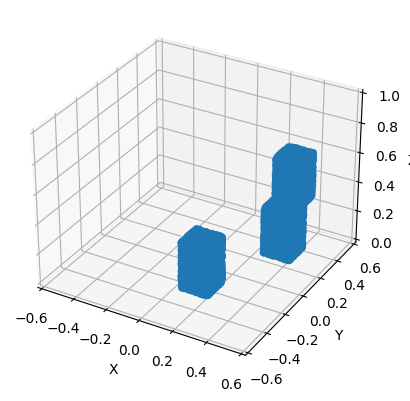

In [1]:
from sdfsc.Obstacles import Obstacle
import matplotlib.pyplot as plt
import torch
obstacles = [
    ('cuboid', [0.3, -0.5, 0.4], [0.15, 0.15, 0.3],3333),
    ('cuboid', [0.5, 0, 0.4], [0.15, 0.15, 0.3],3333),
    ('cuboid', [0.3, 0.5, 0.4], [0.15, 0.15, 0.3],3334)
]
obstacles = [Obstacle(*obstacle) for obstacle in obstacles]
points_list = []
# 遍历obstacles列表
for i in range(len(obstacles)):
    # 获取当前障碍物的点集并转换为PyTorch张量
    points = obstacles[i].points
    # 将当前点集添加到列表中
    points_list.append(points)
# 使用torch.cat函数将所有点集张量连接起来
all_points = torch.cat(points_list, dim=0)
# 打印或使用连接后的所有点集
print(all_points.shape)
# 创建3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-0.6, 0.6)  # x轴范围从x_min到x_max
ax.set_ylim(-0.6, 0.6)  # y轴范围从y_min到y_max
ax.set_zlim(0, 1)  # z轴范围从z_min到z_max
# 绘制3D点云
ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2])
# 设置坐标轴标签
ax.set_xlabel('X ')
ax.set_ylabel('Y ')
ax.set_zlabel('Z ')
# 显示图形
plt.show()

In [2]:
from envs.rtb import PandaThreeCylinderEnv,PandaCuboidEnv
cenv = PandaCuboidEnv(launch_args={'realtime': True, 'browser': 'notebook'})

/home/lichalab/anaconda3/envs/omplall/lib/python3.8/site-packages/spatialgeometry/geom/Shape.py:81: FutureWarning: base kwarg is deprecated, use pose instead
  warn("base kwarg is deprecated, use pose instead", FutureWarning)


In [3]:
from sdfsc.colchecker import colchecker
torch.set_printoptions(sci_mode=False)
checker=colchecker(use_selfcol=False)
checker.get_points(all_points)
col_func=checker.get_scores
q=cenv.sample_q()
# q=[-2.15529761 , 0.33602764 ,-2.74763465 ,-2.23211741  ,2.78082396  ,1.19913325,-2.64666784]
q_tensor=torch.tensor(q, dtype=torch.float32, device='cuda',requires_grad=True)
score=col_func(q_tensor)
print(score)
import torch
jac = torch.autograd.functional.jacobian(
    lambda x: col_func(x), 
    q_tensor,
    create_graph=False, strict=False,
    vectorize=True, strategy='reverse-mode'
)
print(jac)


tensor([[0.3357]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[0.1017, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')


/home/lichalab/SDFSC/sdfsc/colchecker.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.points = torch.tensor(points, dtype=torch.float32, device='cuda')


In [4]:
import time
q_dq=q_tensor+jac.squeeze()*1e-2
start_time = time.time()  # 记录开始时间
for i in range(1000):
    score=col_func(q_dq)
end_time = time.time()
print(score)
print(f"单次查询运行时间：{end_time - start_time} ms")

start_time = time.time()  # 记录开始时间
jac = torch.autograd.functional.jacobian(
    lambda x: col_func(x), 
    q_dq,
    create_graph=False, strict=False,
    vectorize=True, strategy='reverse-mode'
)
end_time = time.time()  # 记录结束时间
print(jac)
print(f"程序运行时间：{(end_time - start_time)*1000} ms")

tensor([[0.3358]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
单次查询运行时间：1.369265079498291 ms
tensor([[[0.1012, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')
程序运行时间：3.2134056091308594 ms
